<a href="https://colab.research.google.com/github/joaochenriques/WE_LAB_2023/blob/main/OWC_ExpAnalysis_V23C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import h5py, re
import matplotlib.pyplot as mpl
import numpy as np
import pandas as pd
import scipy.signal
from dataclasses import dataclass, field
import os, pathlib

In [2]:
if not pathlib.Path("YB2m_Tests_V5.h5").exists():
  os.system( "curl -O https://raw.githubusercontent.com/joaochenriques/WE_LAB_2023/main/YB2m_Tests_V5.zip" )
  os.system( "unzip YB2m_Tests_V5.zip" )
   
if not pathlib.Path("YB4m_Tests_V5.h5").exists():
  os.system( "curl -O https://raw.githubusercontent.com/joaochenriques/WE_LAB_2023/main/YB4m_Tests_V5.zip" )
  os.system( "unzip YB4m_Tests_V5.zip" )

In [27]:
if not pathlib.Path("mpl_utils.py").exists():
  os.system( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" ) 

import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

mpl.rcParams["figure.figsize"] = (6,4.5)

In [4]:
tests_filename = 'YB4m_Tests_V5'
save_time_series_in_EXCEL = True
os.system( "pip install xlsxwriter" )

0

In [5]:
results_folder = './'

if not os.path.isdir( results_folder ):
    try: 
        os.mkdir( results_folder ) 
    except OSError as error: 
        print(error)    

In [6]:
def read_hdf_array( hdf5_Input, group, name ):
    return np.array( hdf5_Input[ group + '/' + name ] )

def read_hdf_scalar( hdf5_Input, group, name ):
    return hdf5_Input[ group + '/' + name ][()]

def read_hdf_string( hdf5_Input, group, name ):
    return hdf5_Input[ group + '/' + name ][()]

def save_hdf_array( hdf5_Output, group, name, fdata ):
    hdf5_Output.create_dataset( group + '/' + name, data=fdata, 
                                compression="gzip", compression_opts=9  )

def save_hdf_scalar( hdf5_Output, group, name, fdata ):
    hdf5_Output.create_dataset( group + '/' + name, data=fdata )

def save_hdf_string( hdf5_Output, group, name, fdata ):
    hdf5_Output.create_dataset( group + '/' + name, data=fdata, 
                                dtype=save_hdf_string.dt_str )
save_hdf_string.dt_str = h5py.special_dtype( vlen=bytes )

## Functions used in the post-processing phase

Filter using convolution and neglecting the ends

In [7]:
def FilterSignal( coeffs, time, unf_signal ):

  NS = unf_signal.shape[0]
  NC = coeffs.shape[0]

  assert( NC % 2 > 0 ) # assert that is a centred filter (odd)

  flt_signal = np.convolve( unf_signal, coeffs, 'valid')
  hNC = int( NC / 2 )
  flt_time = time[ hNC: NS-hNC ]

  assert( flt_time.shape[0] == flt_signal.shape[0] )

  return flt_time, flt_signal

Sinc filter with a Gaussian window

Further information about this filter can be found at the web site
    <http://www.dspguide.com/ch16.htm>

In [8]:
def FilterSincGaussian( window, fc, sigma ):
  M = int( window / 2 )
  pnts = np.linspace( -M, M, 2*M+1 ) / M
  LP_coefs  = 2.0 * np.sinc( fc * pnts ) * np.exp( -0.5*pnts**2/sigma**2 )
  LP_coefs /= sum(LP_coefs)
  return LP_coefs

Filter frequency response function

In [9]:
def FilterResponse( LPF_coefs, points = 2000, lowpow = -6, highpow = 0 ):

  NT = LPF_coefs.shape[0]
  delta_f = 1.0 / points

  m  = int( ( NT-1 ) / 2 )
  omega_star = np.zeros( points )
  H = np.zeros( points )

  a = highpow - lowpow
  js = ( -1J * np.pi ) * np.linspace( -m, m, 2*m+1 )

  for i in range( points ):
    omega_star[i] = 10**(a * delta_f * i + lowpow )
    eiwt = np.exp( omega_star[i] * js )
    G = np.dot( LPF_coefs, eiwt )
    H[i] = np.real( G )

  return omega_star, H

Plot filter specifications


In [10]:
def PlotFilterSpecs( LP_coefs, fsample, LP_fc, LP_sigma, folder ):

    LP_omega, LP_H = FilterResponse( LP_coefs )
    LP_omega *= fsample
    
    fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4.5) )
    fig.subplots_adjust( wspace = 0.17 )

    lbl= r"$f_s=%.1f,\ f_c=%.1f,\ \sigma=%.2f$" % ( fsample, LP_fc, LP_sigma )
    ax1.semilogy( LP_omega, LP_H, label = lbl )
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('frequency, [Hz]')
    ax1.set_ylabel('Gain, [-]')
    
    ax2.plot( LP_omega, LP_H )
    ax2.grid()
    ax2.set_xlabel('frequency, [Hz]')
    ax2.set_ylabel('Gain, [-]')

    filename = 'Low_Pass_Filter'
    # for pdflatex
    mpl.savefig( results_folder + filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

    # for MS WORD
    mpl.savefig( results_folder + filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
    mpl.savefig( results_folder + filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

## Post-Process functions

To compute the wave length $\lambda$ we need to use the dispersion relation

\begin{equation*} 
\omega^{2}=g k \tanh (k h),
\end{equation*}

where the wavelength is defined as

\begin{equation*} 
k=\frac{2\pi}\lambda.
\end{equation*}

Explicit formula for the dispersion relation was obtained by [1] as

\begin{equation*}
k h=\left(k_{0} h\right) \sqrt{1+\frac{1}{\varepsilon+k_{0} h\left(1+D_{1}\left(k_{0} h\right)+D_{2}\left(k_{0} h\right)^{2}+D_{4}\left(k_{0} h\right)^{4}+D_{5}\left(k_{0} h\right)^{5}\right)^{2}}}
\end{equation*}

where the constants are given by $D_{1}=0.6522, D_{2}=0.4622, D_{4}=0.0864$ and $D_{5}=0.0675$.

A small $\varepsilon=10^{-12}$ was added to avoid division by zero when $\omega=0$.

The wave number for infinite depth water conditions is given by

$\displaystyle k_0 h = \frac{\omega^2 h}g$.

[1] Zai-Jin You. A close approximation of wave dispersion relation for direct calculation of
wavelength in any coastal water depth. *Applied Ocean Research*, 30(2):113 – 119, 2008.






In [11]:
def dispersion_relation( ω, h ):
    grav = 9.81
    k0h = h * ω**2 / grav
    return ( k0h*np.sqrt(1.0 + 1.0/(1E-12+k0h*(1. + 0.6522*k0h + 0.4622*k0h**2 + 0.0864*k0h**4 + 0.0675*k0h**5))))

Phase velocity is computed from

\begin{equation*}
c_{p}^{2}=\frac{g}{k} \tanh (k h)=\frac{g\lambda}{2\pi} \tanh\!\left(\frac{2\pi h}{\lambda}\right).
\end{equation*}

In [12]:
def phase_velocity( λ, h ):
    grav = 9.81
    twopi = 2.0 * np.pi
    return np.sqrt( grav * λ / twopi * np.tanh( twopi * h / λ ) )

Mean wave power per unit wave crest

\begin{equation*}
\bar{P}_\text{wave} = \bar{E} \, c_g,
\end{equation*}

where

\begin{equation*}
\bar{E} = \frac{1}{8} \rho_\text{w} g H^2,
\end{equation*}

and

\begin{equation*}
c_g = \frac{\omega h}{2kh} \left( 1 + \frac{2kh}{\sinh(2kh)}\right).
\end{equation*}


In [13]:
def wave_power( cnt, h, H, f ):  
    ω = 2.0 * np.pi * f
    two_kh = 2.0 *  dispersion_relation( ω, h )
    c_g = ω * h / two_kh * ( 1.0 + two_kh / np.sinh(two_kh) )
    E = 1.0 / 8.0 * cnt.𝜌_w * cnt.grav * H**2
    return E * c_g

Function to compute the mean and the amplitude of a signal within a given interval [i_left, i_right]

## Post-processing of the data

Constants of the problem

In [14]:
@dataclass
class constants:

    𝜌_w: float = 998.0        # [kg/m³] - water density
    𝜌_air: float = 1.21       # [kg/m³] - air density
    grav: float = 9.81        # [m/s²]  - gravity acceleration

    # post-process assumptions
    t_hist: float = 6.0       # [s] - estimated OWC history time
    t_ramp: float = 6.0       # [s] - wavemake maximum ramp time 

    # filter configuration
    LP_fsample: int = 200     # [Hz] - sampling rate  
    LP_window: int = 301      # [-] - window of the filter  
    LP_fc: float = 10.0       # [Hz] - estimated cutting frequency of the filter
    LP_sigma: float = 0.35    # [-] - slope of the filter 

Let us define a filter for post-processing (especially for the pressure signal)

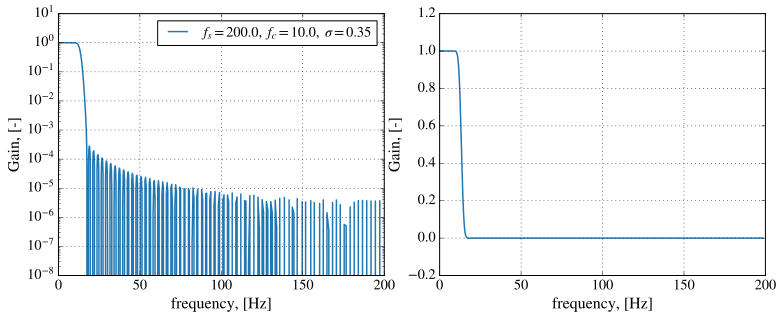

In [15]:
consts = constants()

LP_coefs = FilterSincGaussian( consts.LP_window, consts.LP_fc, consts.LP_sigma  )
PlotFilterSpecs( LP_coefs, consts.LP_fsample, consts.LP_fc, consts.LP_sigma, results_folder )

In [16]:
def compute_working_time_interval( times, wave_h, fsample, cp, L_beach, L_waveProbe, L_buoy ):

    #################################################################
    # Find wave peaks

    # Peak finder spaced at least by fs/4 sec.
    skip = fsample // 4 

    # minimum distance between extrema to be used in find_peaks
    wave_h_thr = np.max( ( np.max( wave_h ), -np.min( wave_h ) ) ) / 5.0

    wave_upper_peaks_indx, _ = scipy.signal.find_peaks(  wave_h, height = wave_h_thr, distance = skip )
    wave_lower_peaks_indx, _ = scipy.signal.find_peaks( -wave_h, height = wave_h_thr, distance = skip )

    times_upper_peaks = times[wave_upper_peaks_indx]
    times_lower_peaks = times[wave_lower_peaks_indx]

    wave_upper_peaks = wave_h[wave_upper_peaks_indx]
    wave_lower_peaks = wave_h[wave_lower_peaks_indx]

    #################################################################
    # Compute the upper/lower peaks ramp-up
    h0 = wave_h[wave_upper_peaks_indx[0]]
    i0 = 0
    for i in range( 1, len( wave_upper_peaks_indx ) ):
        if h0 >= wave_h[wave_upper_peaks_indx[i]]:
            break
        else:
            h0 = wave_h[wave_upper_peaks_indx[i]]
            i0 = i

    h0 = wave_h[wave_lower_peaks_indx[0]]
    j0 = 0
    for j in range( 1, len( wave_lower_peaks_indx ) ):
        if h0 <= wave_h[wave_lower_peaks_indx[j]]:
            break
        else:
            h0 = wave_h[wave_lower_peaks_indx[j]]
            j0 = j

    #################################################################
    # find first peak
    t0 = min( times[wave_upper_peaks_indx[i0]], times[wave_lower_peaks_indx[j0]] )

    #################################################################
    # The last peak 
    t1 = t0 + ( (L_beach-L_waveProbe) + (L_beach - L_buoy ) ) / cp

    return t0, t1

In [17]:
def compute_peaks( times, __signal, fsample, t0, t1 ):
    
    signal  = np.copy( __signal )
    signal -= np.mean( signal )

    #################################################################
    # amplitudes
    signal_thr = np.max( ( np.max( signal ), -np.min( signal ) ) ) / 5.0

    # Peak finder spaced at least by fs/4 sec.
    skip = fsample // 4 

    upper_peaks_indx, _ = scipy.signal.find_peaks(  signal, height = signal_thr, distance = skip )
    lower_peaks_indx, _ = scipy.signal.find_peaks( -signal, height = signal_thr, distance = skip )

    times_upper_peaks = times[upper_peaks_indx]
    times_lower_peaks = times[lower_peaks_indx]

    upper_peaks = __signal[upper_peaks_indx]
    lower_peaks = __signal[lower_peaks_indx]

    up_cond = np.logical_and( t0 <= times_upper_peaks, times_upper_peaks <= t1 )
    lw_cond = np.logical_and( t0 <= times_lower_peaks, times_lower_peaks <= t1 )

    # ensure that both upper and lower arrays have the same number of elements
    lup = len( np.where( up_cond == True )[0] )
    llw = len( np.where( lw_cond == True )[0] )

    if lup < llw:
        entries = np.where( lw_cond == True )[0]
        lw_cond[ entries[-1] ] =False
    if lup > llw:
        entries = np.where( up_cond == True )[0]
        up_cond[ entries[-1] ] =False

    # get the peaks
    times_upper_peaks = times_upper_peaks[ up_cond ]
    upper_peaks = upper_peaks[ up_cond ]

    times_lower_peaks = times_lower_peaks[ lw_cond ]
    lower_peaks = lower_peaks[ lw_cond ]

    return times_lower_peaks, times_upper_peaks, lower_peaks, upper_peaks

In [24]:
@dataclass
class test_data:

    def __init__( self, filename, consts ):
        # read data file of all tests
        hf = h5py.File( filename, 'r' )

        # list of the cases names
        # prefix "xp_" means experimental data 
        self.xp_cases_names = list( hf.keys() )

        # Create data structures for all the values needed
        self.xp_fsample = {}
        self.xp_freq = {}
        self.xp_D_orif = {}
        self.xp_D_OWC = {}
        self.xp_h_depth = {}
        self.xp_L_beach = {}
        self.xp_L_buoy = {}
        self.xp_L_waveProbe = {}
        self.xp_H_des = {}

        self.xp_times = {}
        self.xp_wave_h = {}
        self.xp_OWC_h = {}
        self.xp_OWC_p = {}

        self.flt_times = {}
        self.flt_wave_h = {}
        self.flt_OWC_h = {}
        self.flt_OWC_p = {}

        self.consts = consts

        for case_name in self.xp_cases_names:
            print( case_name )

            self.xp_fsample[case_name] = hf.get( case_name + '/fsample' )[()]
            self.xp_freq[case_name]    = hf.get( case_name + '/freq' )[()]
            self.xp_D_orif[case_name]  = hf.get( case_name + '/D_orifice' )[()]
            self.xp_D_OWC[case_name]   = hf.get( case_name + '/D_OWC' )[()]
            self.xp_h_depth[case_name] = hf.get( case_name + '/h_depth' )[()]
            
            self.xp_L_beach[case_name] = hf.get( case_name + '/L_beach' )[()]
            self.xp_L_buoy[case_name] = hf.get( case_name + '/L_buoy' )[()]
            self.xp_L_waveProbe[case_name]   = hf.get( case_name + '/L_waveProbe' )[()]
            self.xp_H_des[case_name]   = hf.get( case_name + '/H' )[()]
            
            xp_times   = np.array( hf.get( case_name + '/time' ) )
            xp_wave_h = np.array( hf.get( case_name + '/WaveProbe_Ch' ) )
            xp_OWC_h   = np.array( hf.get( case_name + '/WaveProbe_Buoy' ) )
            xp_OWC_p   = np.array( hf.get( case_name + '/Delta_p' ) )

            self.xp_times[case_name]   = xp_times
            self.xp_wave_h[case_name] = xp_wave_h
            self.xp_OWC_h[case_name]   = xp_OWC_h
            self.xp_OWC_p[case_name]   = xp_OWC_p

            flt_times, flt_wave_h = FilterSignal( LP_coefs, xp_times, xp_wave_h )
            flt_times, flt_OWC_h   = FilterSignal( LP_coefs, xp_times, xp_OWC_h )
            flt_times, flt_OWC_p   = FilterSignal( LP_coefs, xp_times, xp_OWC_p )
 
            self.flt_times[case_name]   = flt_times
            self.flt_wave_h[case_name] = flt_wave_h
            self.flt_OWC_h[case_name]   = flt_OWC_h
            self.flt_OWC_p[case_name]   = flt_OWC_p
            
        hf.close() 
    
    def process_cases( self ):

        cnt = self.consts
        twopi = 2.0 * np.pi

        n_cases = len( TD.xp_cases_names ) 

        # prefix "pp_" post-processed data
        self.pp_freq_lst = np.zeros( n_cases )       # array of frequencies
        self.pp_cp_lst = np.zeros( n_cases )         # array of phase velocity
        
        self.pp_t1_lst = np.zeros( n_cases )         # array of t1
        self.pp_t2_lst = np.zeros( n_cases )         # array of t2
        self.pp_t3_lst = np.zeros( n_cases )         # array of t3
        self.pp_t4_lst = np.zeros( n_cases )         # array of t4

        self.pp_wave_amp_lst = np.zeros( n_cases )   # array of mean wave amplitude
        self.pp_OWC_h_amp_lst = np.zeros( n_cases )  # array of OWC mean amplitude
        self.pp_OWC_p_amp_lst = np.zeros( n_cases )  # array of OWC pressure mean amplitude
        self.pp_RAO_lst = np.zeros( n_cases )        # array of RAOs
        self.pp_Pwave_lst = np.zeros( n_cases )      # array of wave power
        self.pp_Pturb_lst = np.zeros( n_cases )      # array of turbine power
        self.pp_CWR_lst = np.zeros( n_cases )        # array of CWR
        self.pp_λ_lst = np.zeros( n_cases )          # array of wavelength
        self.pp_λh_lst = np.zeros( n_cases )          # array of wavelength/depth
        self.pp_kh_lst = np.zeros( n_cases )         # array of k*h
        self.pp_Pwave_des_lst = np.zeros( n_cases )  # array of desired wave power 

        for num, case_key in enumerate( TD.xp_cases_names ):

            #========================================================================
            # variables of this test cases
            fsample = self.xp_fsample[ case_key ]   # sampling frequency
            freq = self.xp_freq[ case_key ]         # Wave Frequency
            D_OWC = self.xp_D_OWC[ case_key ]
            h_depth = self.xp_h_depth[ case_key ]
            L_beach = self.xp_L_beach[ case_key ]
            L_buoy = self.xp_L_buoy[ case_key ]
            L_waveProbe = self.xp_L_waveProbe[ case_key ]

            times = self.flt_times[ case_key ]

            wave_h = self.flt_wave_h[ case_key ]
            wave_h -= np.mean( wave_h )

            OWC_h = self.flt_OWC_h[ case_key ]
            # OWC_h -= np.mean( OWC_h )

            OWC_p = self.flt_OWC_p[ case_key ]
            # OWC_p -= np.mean( OWC_p )
            
            Do = self.xp_D_orif[ case_key ]
            H_des = self.xp_H_des[ case_key ]

            #========================================================================
            # Wave characteristics
            ω  = twopi * freq                       # Angular Frequency
            kh = dispersion_relation( ω, h_depth )  # Wave Number for infinite depth water conditions
            k  = kh / h_depth                       # Wave Number
            cp = ω / k                              # Wave crest Speed or phase Velocity
            λ  = twopi / k                          # Wave Length
            λh  = twopi / kh                        # Wave Length/ Depth
            Tw = 1.0 / freq                         # wave period

            #========================================================================
            # time interval used for mean values
            t0, t1 = compute_working_time_interval( times, wave_h, fsample, cp, L_beach, L_waveProbe, L_buoy )

            #========================================================================
            # Compute means
            waves_times_lower_peaks, waves_times_upper_peaks, \
                waves_lower_peaks, waves_upper_peaks = compute_peaks( times, wave_h, fsample, t0, t1 )
            wave_amp = 0.5 * ( np.mean( waves_upper_peaks ) - np.mean( waves_lower_peaks ) )

            #========================================================================
            # wave power [W]
            Pwave = wave_power( cnt, h_depth, 2.0*wave_amp, freq )
            Pwave *= D_OWC

            # desired wave power [W]
            Pwave_des = wave_power( cnt, h_depth, H_des, freq ) 
            Pwave_des *= D_OWC
            
            #========================================================================
            # Compute the OWC motion amplitute
            OWC_h_times_lower_peaks, OWC_h_times_upper_peaks, \
                OWC_h_lower_peaks, OWC_h_upper_peaks = compute_peaks( times, OWC_h, fsample, t0, t1 )
            OWC_h_amp = 0.5 * ( np.mean( OWC_h_upper_peaks ) - np.mean( OWC_h_lower_peaks ) )


            #========================================================================
            # Compute the OWC motion amplitute
            # Peak finder spaced at least by fs/4 sec.
            OWC_p_times_lower_peaks, OWC_p_times_upper_peaks, \
                OWC_p_lower_peaks, OWC_p_upper_peaks = compute_peaks( times, OWC_p, fsample, t0, t1 )
            OWC_p_amp = 0.5 * ( np.mean( OWC_p_upper_peaks ) - np.mean( OWC_p_lower_peaks ) )
            
            # ========================================
            # Compute turbine power
            tt0 = np.min( ( OWC_p_times_lower_peaks[ 0], OWC_p_times_upper_peaks[ 0] ) )
            tt1 = np.min( ( OWC_p_times_lower_peaks[-1], OWC_p_times_upper_peaks[-1] ) )

            t_cond = np.logical_and( tt0 <= times, times <= tt1 )
            ttimes = times[ t_cond ]
            tOWC_p = OWC_p[ t_cond ]
            
            Ao = np.pi * Do**2 / 4.0
            Cd = 0.65
            Co = np.sqrt( 2.0 ) * Ao * Cd 
            Q_turb = np.sign( tOWC_p ) * Co * np.sqrt( np.abs( tOWC_p ) / cnt.𝜌_air )
            P_turb = tOWC_p * Q_turb
            Pturb = np.mean( P_turb )

            #========================================================================
            self.pp_freq_lst[num] = np.round( freq, 2 )
            self.pp_cp_lst[num] = np.round( cp, 2 )

            self.pp_wave_amp_lst[num]  = np.round( wave_amp, 4 )
            self.pp_OWC_h_amp_lst[num] = np.round( OWC_h_amp, 4 )
            self.pp_OWC_p_amp_lst[num] = np.round( OWC_p_amp, 2 )
            self.pp_RAO_lst[num] = np.round( OWC_h_amp / wave_amp, 3 )
            self.pp_Pwave_lst[num] = np.round( Pwave, 3 )
            self.pp_Pturb_lst[num] = np.round( Pturb, 3 )
            self.pp_CWR_lst[num] = np.round( Pturb / Pwave, 3 )
            self.pp_λ_lst[num] = np.round( λ, 2 )
            self.pp_λh_lst[num] = np.round( λh, 2 )
            self.pp_kh_lst[num] = np.round( kh, 4 )
            self.pp_Pwave_des_lst[num] = np.round( Pwave_des, 2 )
        

In [25]:
TD = test_data( tests_filename + '.h5', consts )
TD.process_cases()

YB4m_H0.04m_f0.30Hz
YB4m_H0.04m_f0.50Hz
YB4m_H0.04m_f0.60Hz
YB4m_H0.04m_f0.64Hz
YB4m_H0.04m_f0.70Hz
YB4m_H0.04m_f0.74Hz
YB4m_H0.04m_f0.76Hz
YB4m_H0.04m_f0.80Hz
YB4m_H0.04m_f0.84Hz
YB4m_H0.04m_f0.88Hz
YB4m_H0.04m_f0.90Hz
YB4m_H0.04m_f0.92Hz
YB4m_H0.04m_f0.96Hz
YB4m_H0.04m_f1.00Hz
YB4m_H0.04m_f1.02Hz
YB4m_H0.04m_f1.06Hz
YB4m_H0.04m_f1.08Hz
YB4m_H0.04m_f1.10Hz
YB4m_H0.04m_f1.12Hz
YB4m_H0.04m_f1.14Hz
YB4m_H0.04m_f1.16Hz
YB4m_H0.04m_f1.18Hz
YB4m_H0.04m_f1.20Hz
YB4m_H0.04m_f1.24Hz
YB4m_H0.04m_f1.28Hz
YB4m_H0.04m_f1.30Hz
YB4m_H0.04m_f1.34Hz
YB4m_H0.04m_f1.40Hz
YB4m_H0.04m_f1.50Hz


In [26]:
data =  {   "Freq [Hz]": TD.pp_freq_lst, 
            "kh [-]" : TD.pp_kh_lst, 
            "λ [m]" : TD.pp_λ_lst,
            "λ/h [m]" : TD.pp_λh_lst,
            "crest speed [m/s]" : TD.pp_cp_lst,
            "wave amp [m]": TD.pp_wave_amp_lst, 
            "OWC_h amp [m]": TD.pp_OWC_h_amp_lst, 
            "RAO": TD.pp_RAO_lst, 
            "Pwave × w_OWC [W]": TD.pp_Pwave_lst, 
            "Pwave_des × w_OWC [W]": TD.pp_Pwave_des_lst, 
            "OWC_p amp [Pa]": TD.pp_OWC_p_amp_lst, 
            "Pturb [W]": TD.pp_Pturb_lst,
            "CWR [-]": TD.pp_CWR_lst,
            "t1 [s]": TD.pp_t1_lst, "t2 [s]": TD.pp_t2_lst, 
            "t3 [s]": TD.pp_t3_lst, "t4 [s]": TD.pp_t4_lst
        }

# Create Excel File
XLS_filename = results_folder + tests_filename + '.xlsx'
writer = pd.ExcelWriter( XLS_filename, engine='xlsxwriter' )

workbook  = writer.book
right = workbook.add_format( {'align': 'right'} )
header_format = workbook.add_format( { 'fg_color': '#FFFF00', 'border': 1,
                                    'align' : 'center' } )

if save_time_series_in_EXCEL:
  for case_key in TD.xp_cases_names:
      freq = TD.xp_freq[ case_key ]         # Wave Frequency

      flt_times = TD.flt_times[ case_key ]

      flt_wave_h = TD.flt_wave_h[ case_key ]
      flt_OWC_h = TD.flt_OWC_h[ case_key ]
      flt_OWC_p = TD.flt_OWC_p[ case_key ]

      data_freq = { "times": flt_times, 
              "flt_wave_h": flt_wave_h,
              "flt_OWC_h": flt_OWC_h,
              "flt_OWC_p": flt_OWC_p
            }    
      df_freq = pd.DataFrame( data_freq )
      df_freq.to_excel( writer, index=False, sheet_name='f%.2fHz' % freq )

df = pd.DataFrame( data )
df.to_excel( writer, index=False, sheet_name='Summary' )

worksheet = writer.sheets['Summary']
worksheet.set_column( 'A:P', 14, right )

# Write the column headers with the defined format
for col_num, value in enumerate(df.columns.values):
    worksheet.write( 0, col_num, value, header_format )
worksheet.freeze_panes(1, 1)
writer.save()

df

,Freq [Hz],kh [-],λ [m],λ/h [m],crest speed [m/s],wave amp [m],OWC_h amp [m],RAO,Pwave × w_OWC [W],Pwave_des × w_OWC [W],OWC_p amp [Pa],Pturb [W],CWR [-],t1 [s],t2 [s],t3 [s],t4 [s]
0,0.30,0.4332,7.08,14.50,2.12,0.0138,0.0033,0.236,0.298,0.63,1.83,0.000,0.000,0.0,0.0,0.0,0.0
1,0.50,0.7631,4.02,8.23,2.01,0.0099,0.0030,0.303,0.130,0.53,0.88,0.000,0.000,0.0,0.0,0.0,0.0
2,0.60,0.9537,3.22,6.59,1.93,0.0097,0.0059,0.605,0.112,0.48,2.63,0.000,0.000,0.0,0.0,0.0,0.0
3,0.64,1.0365,2.96,6.06,1.89,0.0093,0.0087,0.937,0.097,0.45,6.80,0.000,0.001,0.0,0.0,0.0,0.0
4,0.70,1.1689,2.62,5.38,1.84,0.0107,0.0151,1.415,0.119,0.42,24.11,0.000,0.003,0.0,0.0,0.0,0.0
5,0.74,1.2632,2.43,4.97,1.80,0.0108,0.0188,1.747,0.115,0.40,40.74,0.001,0.006,0.0,0.0,0.0,0.0
6,0.76,1.3123,2.34,4.79,1.78,0.0077,0.0169,2.208,0.056,0.38,34.61,0.001,0.009,0.0,0.0,0.0,0.0
7,0.80,1.4149,2.17,4.44,1.73,0.0113,0.0221,1.948,0.116,0.36,66.10,0.001,0.012,0.0,0.0,0.0,0.0
8,0.84,1.5236,2.01,4.12,1.69,0.0109,0.0228,2.093,0.102,0.34,74.85,0.002,0.017,0.0,0.0,0.0,0.0
9,0.88,1.6390,1.87,3.83,1.65,0.0115,0.0238,2.075,0.106,0.32,87.60,0.002,0.020,0.0,0.0,0.0,0.0


## Data analysis

Plot one of the cases

In [ ]:
case_num = 18
case_key = TD.xp_cases_names[ case_num ]

fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4.5) )
fig.subplots_adjust( wspace = 0.17 )

fsample = TD.xp_fsample[ case_key ]   # sampling frequency
freq    = TD.xp_freq[ case_key ]         # Wave Frequency

times   = TD.flt_times[ case_key ]
wave_h = TD.flt_wave_h[ case_key ]
OWC_h   = TD.flt_OWC_h[ case_key ]
OWC_p   = TD.flt_OWC_p[ case_key ]

xp_times  = TD.xp_times[ case_key ]
xp_OWC_p  = TD.xp_OWC_p[ case_key ]
xp_OWC_p -= np.mean( xp_OWC_p )

ax1.set_title( case_key.replace( '_', ' ' ) )
ax1.plot( times, wave_h, '-', label="wave height probe '2nd' [m]" )
ax1.plot( times, OWC_h, '-', label='OWC height [m]' )
ax1.set_xlim( 10, 60 )
ax1.legend( loc='upper left' )
ax1.set_xlabel( 'time [s]')

ax2.plot( xp_times, xp_OWC_p, label='OWC $\Delta p$ unfiltered [Pa]' )
ax2.plot( times, OWC_p, label='OWC $\Delta p$ [Pa]' )
ax2.set_xlim( 45, 50 )
# ax2.set_ylim( 400, 1100 )
ax2.legend( loc='upper left' )
ax2.set_xlabel( 'time [s]');

In [ ]:
# Check file to find wave height. File needs to be named 'TypeOfWave_HX.XXX_Tests.h5'.
case_num = 4
case_key = TD.xp_cases_names[ case_num ] # Choose from 0 to N-1 number of tests made

H_des = float( re.findall('\d*\.?\d+', case_key)[0] ) 

# Plot wave height graph with peaks and analysis zone

freq = TD.xp_freq[ case_key ]         # Wave Frequency
times = TD.xp_times[ case_key ]

wave_h = TD.xp_wave_h[ case_key ]
OWC_h = TD.xp_OWC_h[ case_key ]
OWC_p = TD.xp_OWC_p[ case_key ]

t1 = TD.pp_t1_lst[ case_num ]
t2 = TD.pp_t2_lst[ case_num ]
t3 = TD.pp_t3_lst[ case_num ]
t4 = TD.pp_t4_lst[ case_num ]

mpl.figure(1)
mpl.axvspan( t1, t2, color='#e5ffd5c2')
mpl.axvline( t1, dashes=(5,1.5,1.5,1.5), color='g', label='wave - $t_1$' )
mpl.axvline( t2, dashes=(5,1.5), color='g', label='wave - $t_2$' )

mpl.plot( times, wave_h, label='wave height' )

mpl.grid()
mpl.legend(loc='upper left', fontsize=12)
mpl.xlabel( "Measuring time [s]" )
mpl.ylabel( "Wave height [m]" )
mpl.title( "Wave proble '2nd': " + "$H = %1.3f\,$m" % H_des + ", " + "$f = %1.2f\,$Hz" % freq ) 
mpl.xlim( (t1-10.0, t4+10) )

In [ ]:
# Check file to find wave height. File needs to be named 'TypeOfWave_HX.XXX_Tests.h5'.
case_num = 4
case_key = TD.xp_cases_names[ case_num ] # Choose from 0 to N-1 number of tests made

H_des = float( re.findall('\d*\.?\d+', case_key)[0] ) 

# Plot wave height graph with peaks and analysis zone

freq = TD.xp_freq[ case_key ]         # Wave Frequency
times = TD.xp_times[ case_key ]

wave_h = TD.xp_wave_h[ case_key ]
OWC_h = TD.xp_OWC_h[ case_key ]
OWC_p = TD.xp_OWC_p[ case_key ]

t1 = TD.pp_t1_lst[ case_num ]
t2 = TD.pp_t2_lst[ case_num ]
t3 = TD.pp_t3_lst[ case_num ]
t4 = TD.pp_t4_lst[ case_num ]

# Plot pressure graph with peaks and analysis zone

mpl.figure(2)
mpl.axvspan( t3, t4, color='#e5ffd5c2')
mpl.axvline( t3, dashes=(5,1.5,1.5,1.5), color='g', label='press - $t_3$' )
mpl.axvline( t4, dashes=(5,1.5), color='g', label='press - $t_4$' )

mpl.plot( times, OWC_p, label='chamber pressure' )
mpl.grid()
mpl.legend(loc='upper left', fontsize=12)
mpl.xlim( (t1-10, t4+10) )
mpl.xlabel( "Measuring time [s]" )
mpl.ylabel( "Pressure [Pa]" )
mpl.title( "Chamber pressure: " + "$H = %1.3f\,$m" % H_des + ", " + "$f = %1.2f\,$Hz" % freq )

In [ ]:
# Check file to find wave height. File needs to be named 'TypeOfWave_HX.XXX_Tests.h5'.
case_num = 4
case_key = TD.xp_cases_names[ case_num ] # Choose from 0 to N-1 number of tests made

H_des = float( re.findall('\d*\.?\d+', case_key)[0] ) 

# Plot wave height graph with peaks and analysis zone

freq = TD.xp_freq[ case_key ]         # Wave Frequency
times = TD.xp_times[ case_key ]

wave_h = TD.xp_wave_h[ case_key ]
OWC_h = TD.xp_OWC_h[ case_key ]
OWC_p = TD.xp_OWC_p[ case_key ]

t1 = TD.pp_t1_lst[ case_num ]
t2 = TD.pp_t2_lst[ case_num ]
t3 = TD.pp_t3_lst[ case_num ]
t4 = TD.pp_t4_lst[ case_num ]

mpl.figure(3)
mpl.axvspan( t3, t4, color='#e5ffd5c2')
mpl.axvline( t3, dashes=(5,1.5,1.5,1.5), color='g', label='press - $t_3$' )
mpl.axvline( t4, dashes=(5,1.5), color='g', label='press - $t_4$' )

mpl.plot( times, OWC_h )
mpl.grid()
# mpl.legend(loc='upper left', fontsize=12)
mpl.xlim( (t1-10, t4+10) )
mpl.xlabel( "Measuring time [s]" )
mpl.ylabel( "OWC height [Pa]" )
mpl.title( "OWC height: " + "$H = %1.3f\,$m" % H_des + ", " + "$f = %1.2f\,$Hz" % freq );

In [ ]:
mpl.plot( TD.pp_freq_lst, TD.pp_Pwave_des_lst, 'o-', label=r'desired $P_\mathrm{wave}\times w_\mathrm{OWC}$' )
mpl.plot( TD.pp_freq_lst, TD.pp_Pwave_lst, 'o-', label=r'measured $P_\mathrm{wave}\times w_\mathrm{OWC}$'  )
mpl.plot( TD.pp_freq_lst, TD.pp_Pturb_lst, 's-', label = r'$P_\mathrm{turb}$' )
mpl.xlabel( r"Wave frequency, $f$ [Hz]" )
mpl.ylabel( r"Power [W]")
mpl.legend()
mpl.grid()
# mpl.ylim( 0, 3.0 )

fig_filename = results_folder + tests_filename + '_WaveTurbPower'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

In [ ]:
mpl.plot( TD.pp_freq_lst, TD.pp_CWR_lst, 'o-' )
mpl.xlabel( "Wave frequency, $f$ [Hz]" )
mpl.ylabel( "CWR [-]")
mpl.grid()
mpl.ylim( 0, 0.6 )

fig_filename = results_folder + tests_filename + '_CWR'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

In [ ]:
mpl.plot( TD.pp_freq_lst, TD.pp_RAO_lst, 'o-' )
mpl.xlabel( "Wave frequency, $f$ [Hz]" )
mpl.ylabel( "RAO [-]")
mpl.grid()
# mpl.ylim( 0, 0.35 )

fig_filename = results_folder + tests_filename + '_RAO'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

In [ ]:
mpl.plot( TD.pp_freq_lst, TD.pp_wave_amp_lst, 'o-', label = r'$y_\mathrm{wave}$ [m]' )
mpl.plot( TD.pp_freq_lst, TD.pp_OWC_h_amp_lst, 's-', label = r'$y_\mathrm{OWC}$ [m]' )
mpl.plot( [np.nan], [np.nan],  'Dg-', label='$\Delta p$ [Pa]' )
mpl.xlabel( "Wave frequency, $f$ [Hz]" )
mpl.ylabel( "Displacement [m]")
mpl.grid()
mpl.legend()
mpl.ylim( 0, 0.10 )

ax2 = mpl.gca().twinx()
ax2.plot( TD.pp_freq_lst, TD.pp_OWC_p_amp_lst, 'Dg-' )
ax2.set_ylabel( "Pressure amplitude [Pa]")

fig_filename = results_folder + tests_filename + '_Displacments_Pressure'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

In [ ]:
################################################ kh ###############################################

mpl.plot( TD.pp_kh_lst, TD.pp_Pwave_des_lst, 'o-', label=r'desired $P_\mathrm{wave}\times w_\mathrm{OWC}$' )
mpl.plot( TD.pp_kh_lst, TD.pp_Pwave_lst, 'o-', label=r'measured $P_\mathrm{wave}\times w_\mathrm{OWC}$'  )
mpl.plot( TD.pp_kh_lst, TD.pp_Pturb_lst, 's-', label = r'$P_\mathrm{turb}$' )
mpl.xlabel( r"$kh$ [-]" )
mpl.ylabel( r"Power [W]")
mpl.legend()
mpl.grid()
# mpl.ylim( 0, 3.0 )

fig_filename = results_folder + tests_filename + '_WaveTurbPower' + '_kh'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

In [ ]:
mpl.plot( TD.pp_kh_lst, TD.pp_CWR_lst, 'o-' )
mpl.xlabel( "$kh$ [-]" )
mpl.ylabel( "CWR [-]")
mpl.grid()
mpl.ylim( 0, 0.5 )

fig_filename = results_folder + tests_filename + '_CWR' + '_kh'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

In [ ]:
mpl.plot( TD.pp_kh_lst, TD.pp_RAO_lst, 'o-' )
mpl.xlabel( "$kh$ [-]" )
mpl.ylabel( "RAO [-]")
mpl.grid()
# mpl.ylim( 0, 0.35 )

fig_filename = results_folder + tests_filename + '_RAO' + '_kh'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

In [ ]:
mpl.plot( TD.pp_kh_lst, TD.pp_wave_amp_lst, 'o-', label = r'$y_\mathrm{wave}$ [m]' )
mpl.plot( TD.pp_kh_lst, TD.pp_OWC_h_amp_lst, 's-', label = r'$y_\mathrm{OWC}$ [m]' )
mpl.plot( [np.nan], [np.nan],  'Dg-', label='$\Delta p$ [Pa]' )
mpl.xlabel( "$kh$ [-]" )
mpl.ylabel( "Displacement [m]")
mpl.grid()
mpl.legend()
mpl.ylim( 0, 0.10 )

ax2 = mpl.gca().twinx()
ax2.plot( TD.pp_kh_lst, TD.pp_OWC_p_amp_lst, 'Dg-' )
ax2.set_ylabel( "Pressure amplitude [Pa]")

fig_filename = results_folder + tests_filename + '_Displacments_Pressure' + '_kh'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

In [ ]:
################################################ λ/h ###############################################

mpl.plot( TD.pp_λh_lst, TD.pp_Pwave_des_lst, 'o-', label=r'desired $P_\mathrm{wave}\times w_\mathrm{OWC}$' )
mpl.plot( TD.pp_λh_lst, TD.pp_Pwave_lst, 'o-', label=r'measured $P_\mathrm{wave}\times w_\mathrm{OWC}$'  )
mpl.plot( TD.pp_λh_lst, TD.pp_Pturb_lst, 's-', label = r'$P_\mathrm{turb}$' )
mpl.xlabel( r"$λ/h$ [-]" )
mpl.ylabel( r"Power [W]")
mpl.legend()
mpl.grid()
# mpl.ylim( 0, 3.0 )

fig_filename = results_folder + tests_filename + '_WaveTurbPower'+ '_λh'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

In [ ]:
mpl.plot( TD.pp_λh_lst, TD.pp_CWR_lst, 'o-' )
mpl.xlabel( "$λ/h$ [-]" )
mpl.ylabel( "CWR [-]")
mpl.grid()
mpl.ylim( 0, 0.4 )

fig_filename = results_folder + tests_filename + '_CWR'+ '_λh'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

In [ ]:
mpl.plot( TD.pp_λh_lst, TD.pp_RAO_lst, 'o-' )
mpl.xlabel( "$λ/h$ [-]" )
mpl.ylabel( "RAO [-]")
mpl.grid()
# mpl.ylim( 0, 0.35 )

fig_filename = results_folder + tests_filename + '_RAO'+ '_λh'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

In [ ]:
mpl.plot( TD.pp_λh_lst, TD.pp_wave_amp_lst, 'o-', label = r'$y_\mathrm{wave}$ [m]')
mpl.plot( TD.pp_λh_lst, TD.pp_OWC_h_amp_lst, 's-', label = r'$y_\mathrm{OWC}$ [m]')
mpl.plot( [np.nan], [np.nan],  'Dg-', label='$\Delta p$ [Pa]' )
mpl.xlabel( "$λ/h$ [-]" )
mpl.ylabel( "Displacement [m]")
mpl.grid()
mpl.legend(loc='upper left')
mpl.ylim( 0, 0.10 )

ax2 = mpl.gca().twinx()
ax2.plot( TD.pp_λh_lst, TD.pp_OWC_p_amp_lst, 'Dg-' )
ax2.set_ylabel( "Pressure amplitude [Pa]")

fig_filename = results_folder + tests_filename + '_Displacments_Pressure'+ '_λh'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

In [ ]:
# Create a zip file for download with all the results

In [ ]:
!zip {'RESULTS_'+TEST_CASE_NAME+'.zip'} \
      {TEST_CASE_NAME+'*.xlsx'} \
      {TEST_CASE_NAME+'*.jpg'} \
      {TEST_CASE_NAME+'*.pdf'} \
      {TEST_CASE_NAME+'*.svg'} \
      {'Low_Pass_Filter.*'}

In [ ]:
case_name = TD.xp_cases_names[18]
print( case_name )

xp_times = TD.xp_times[case_name]
xp_wave_h = TD.xp_wave_h[case_name]

times = TD.flt_times[case_name]
wave_h = TD.flt_wave_h[case_name]
OWC_h = TD.flt_OWC_h[case_name]
OWC_p = TD.flt_OWC_p[case_name]

mean_wave_h = np.mean( wave_h )

wave_h -= mean_wave_h
xp_wave_h -= mean_wave_h

freq = TD.xp_freq[ case_name ] 
h_depth = TD.xp_h_depth[ case_name ]
h_depth = TD.xp_h_depth[ case_name ]
L_beach = TD.xp_L_beach[ case_name ]
L_buoy = TD.xp_L_buoy[ case_name ]
L_waveProbe = TD.xp_L_waveProbe[ case_name ]

H_des = 0.02
fsample = 120 

#################################################################
# Wave characteristics
ω  = 2.0 * np.pi * freq                       # Angular Frequency
kh = dispersion_relation( ω, h_depth )  # Wave Number for infinite depth water conditions
k  = kh / h_depth                       # Wave Number
cp = ω / k                              # Wave crest Speed or phase Velocity

t0, t1 = compute_working_time_interval( times, wave_h, fsample, cp, L_beach, L_waveProbe, L_buoy )

waves_times_lower_peaks, waves_times_upper_peaks, \
    waves_lower_peaks, waves_upper_peaks, _, _ = compute_peaks( times, wave_h, fsample, t0, t1 )

OWC_h_times_lower_peaks, OWC_h_times_upper_peaks, \
    OWC_h_lower_peaks, OWC_h_upper_peaks, _, _ = compute_peaks( times, OWC_h, fsample, t0, t1 )

OWC_p_times_lower_peaks, OWC_p_times_upper_peaks, \
    OWC_p_lower_peaks, OWC_p_upper_peaks, n0, n1 = compute_peaks( times, OWC_p, fsample, t0, t1 )

# #################################################################
k0 = np.argmax( times >= t0 )
k1 = np.argmax( times >= t1 )

mpl.figure(1)
mpl.axhline( np.mean( waves_upper_peaks ), color='k', dashes=(6,3) )
mpl.axhline( np.mean( waves_lower_peaks ), color='k', dashes=(6,3) )

mpl.plot( xp_times, xp_wave_h )
mpl.plot( times[k0:k1], wave_h[k0:k1], dashes=(10,0) )

mpl.plot( waves_times_upper_peaks, waves_upper_peaks, 'o' )
mpl.plot( waves_times_lower_peaks, waves_lower_peaks, 'o' )
# mpl.xlim( ( 10, 30 ) )

mpl.figure(2)
mpl.axhline( np.mean( OWC_h_upper_peaks ), color='k', dashes=(6,3) ) 
mpl.axhline( np.mean( OWC_h_lower_peaks ), color='k', dashes=(6,3) )

mpl.plot( times, OWC_h )
mpl.plot( times[k0:k1], OWC_h[k0:k1], dashes=(10,0) )
mpl.plot( OWC_h_times_lower_peaks, OWC_h_lower_peaks, 'o' )
mpl.plot( OWC_h_times_upper_peaks, OWC_h_upper_peaks, 'o' )
# mpl.xlim( ( 10, 30 ) )

mpl.figure(3)
mpl.axhline( np.mean( OWC_p_upper_peaks ), color='k', dashes=(6,3) ) 
mpl.axhline( np.mean( OWC_p_lower_peaks ), color='k', dashes=(6,3) )

mpl.plot( times, OWC_p )
mpl.plot( times[k0:k1], OWC_p[k0:k1], dashes=(10,0) )
mpl.plot( OWC_p_times_lower_peaks, OWC_p_lower_peaks, 'o' )
mpl.plot( OWC_p_times_upper_peaks, OWC_p_upper_peaks, 'o' )
# mpl.xlim( ( 10, 30 ) )

OWC_p01 = OWC_p[n0:n1]



In [ ]:
Do = 0.003

Ao = np.pi * Do**2 / 4.0
Cd = 0.65
Co = np.sqrt( 2.0 ) * Ao * Cd 
Q_turb = np.sign( OWC_p01 ) * Co * np.sqrt( np.abs( OWC_p01 ) / 1.21 )
P_turb = OWC_p01 * Q_turb
Pturb = np.mean( P_turb )


In [ ]:
tt0 = np.min( ( OWC_p_times_lower_peaks[ 0], OWC_p_times_upper_peaks[ 0] ) )
tt1 = np.min( ( OWC_p_times_lower_peaks[-1], OWC_p_times_upper_peaks[-1] ) )

t_cond = np.logical_and( tt0 <= times, times <= tt1 )
ttimes = times[ t_cond ]
tOWC_p = OWC_p[ t_cond ]

In [ ]:
Do = 0.003

Ao = np.pi * Do**2 / 4.0
Cd = 0.65
Co = np.sqrt( 2.0 ) * Ao * Cd 
Q_turb = np.sign( tOWC_p ) * Co * np.sqrt( np.abs( tOWC_p ) / 1.21 )
P_turb = tOWC_p * Q_turb
Pturb = np.mean( P_turb )
Pturb

In [ ]:
tOWC_p